# Load packages

In [87]:
# the Gym environment class
import importlib
import gym2048
importlib.reload(gym2048)

import json
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# used for clearing the display in jupyter notebooks
from IPython.display import clear_output
import os
from tqdm import tqdm
import pickle
from pympler import asizeof
import cProfile
import pstats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from collections import namedtuple, deque
from itertools import count

from gymnasium import spaces

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.buffers import ReplayBuffer

import tensorflow as tf

In [88]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Class gym2048 definition

In [89]:
env = gym2048.gym2048(log_reward=False, max_tile=8192)

In [90]:
gym2048.check_game()


 Check SwipeLeft 

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True

 Check SwipeLeft 

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

 Check encode 

In [91]:
check_env(env, warn=True)

In [92]:
terminated = False

env.reset()

cpt = 0
cum_reward = 0

while terminated == False:
  cpt += 1
  action = random.randrange(0,4)
  observation, reward, terminated, _, _ = env.step(action)
  cum_reward += reward

print(env.unwrapped.decode(observation))
print(cum_reward)
print(cpt)

[[ 8.  2.  2.  4.]
 [ 2.  8. 32.  2.]
 [16. 64.  4. 16.]
 [ 8.  2.  2.  2.]]
552.0
74


In [ ]:
def evaluate(env, model=None, n_games=1000):
  max_tiles = np.array([])
  n_steps = np.array([])

  for k in tqdm(range(n_games)):
    terminated = False
    cpt = 0
    state, _ = env.reset()

    if type(model) != TDL:
      observation = torch.tensor(state, dtype=torch.int16).unsqueeze(0)
    else:
      observation = state

    while terminated == False:
      cpt += 1

      if model:
        with torch.no_grad():
          action, _ = model.predict(observation=observation)
        observation, reward, terminated, _, _ = env.step(action.item())
      else:
        action = random.randrange(0,4)
        observation, reward, terminated, _, _ = env.step(action)

    max_tiles = np.append(max_tiles, np.max(env.unwrapped.decode(observation)))
    n_steps = np.append(n_steps, cpt)

  return max_tiles, n_steps

In [ ]:
if False:
  random_max_tiles, random_n_steps = evaluate(env, n_games=1000)

  data = {
      'max_tiles': random_max_tiles,
      'n_steps': random_n_steps
      }

  with open('./2048_random.pkl', 'wb') as file:
      pickle.dump(data, file)

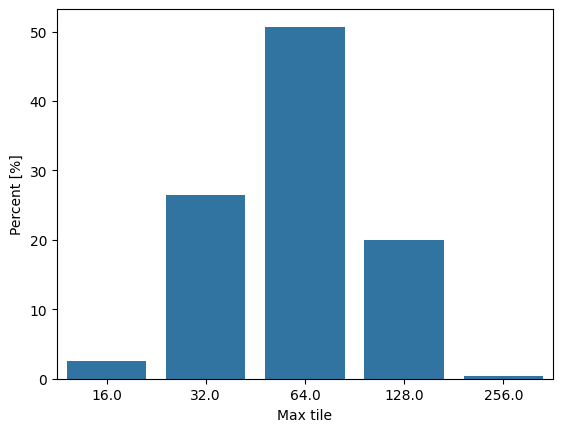

In [ ]:
with open('./2048_random.pkl', 'rb') as file:
    data = pickle.load(file)

df_random = pd.DataFrame({'max_tiles':data['max_tiles']})
df_random['model'] = "Random"

sns.countplot(df_random, x="max_tiles", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent [%]')
plt.show()

# Plot callback & Monitor wrapper

In [10]:
class PlotCallback(BaseCallback):
    def __init__(self, update_freq=1000, window=50, verbose=0):
        super(PlotCallback, self).__init__(verbose)
        self.check_freq = update_freq
        self.episode_rewards = []
        self.episode_reward = 0
        self.fig, self.ax = plt.subplots()

    def _on_step(self) -> bool:
        # Increment the current episode reward with the reward of this step
        self.episode_reward += self.locals["rewards"][0]

        # Check if the episode is done
        if self.locals["dones"][0]:
            # Append the total reward for the completed episode
            self.episode_rewards.append(self.episode_reward)
            # Reset the episode reward
            self.episode_reward = 0

        # Every check_freq steps, update the plot
        if len(self.episode_rewards) % self.check_freq == 0 and len(self.episode_rewards) > 0:
            clear_output(wait=True)  # Clear the previous plot

            # Create a new plot with episode rewards
            plt.figure(figsize=(10, 5))
            plt.plot(self.episode_rewards, label="Episode Reward")
            plt.xlabel("Episodes")
            plt.ylabel("Reward")
            plt.title("Episode Rewards over Time")

            if len(self.episode_rewards) >= 100:
              df = pd.DataFrame({'episode_rewards':self.episode_rewards})
              df['rolling_avg'] = df['episode_rewards'].rolling(window=100).mean()
              plt.plot(df['rolling_avg'])

            plt.legend()
            plt.grid()
            plt.show()

        return True

    def _on_rollout_end(self):
        pass  # This method is not needed anymore, as rewards are now added in _on_step

In [11]:
def check_gradients(model, timestep, save_path='./', threshold_min=1e-6, threshold_max=1e2, verbose=False):
    warnings = []  # Collect warnings to minimize print calls
    
    # Create a list of norms in one pass
    norms = [(name, param.grad.data.norm(2).item()) 
             for name, param in model.named_parameters() 
             if param.grad is not None]
    
    for name, grad_norm in norms:
        if grad_norm < threshold_min:
            warnings.append(f"Warning: Vanishing gradient in layer {name}, norm: {grad_norm}")
        elif grad_norm > threshold_max:
            warnings.append(f"Warning: Exploding gradient in layer {name}, norm: {grad_norm}")
        
        if verbose:
            print(f"Gradient in layer {name}, norm: {grad_norm}")

    # Print all warnings at once
    if warnings:
        with open(save_path+"gradients_log.txt", "a") as file:
            file.writelines(("\n Step " + str(timestep) + "\n"))
            file.writelines(("\n").join(warnings))

# CNN22

In [12]:
class CNN22(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super(CNN22, self).__init__(observation_space, features_dim)

        # Extract observation dimensions
        n_input_channels = observation_space.shape[0]

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 256, kernel_size=2, stride=1),  # 1st conv layer
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=1),  # 2nd conv layer
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size of the CNN
        with torch.no_grad():
            # We assume the input is a square image (check this based on your environment)
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        # Fully connected layers after CNN
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Linear(1024, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Forward pass through CNN and FC layers
        return self.fc(self.cnn(observations))

# Use the custom feature extractor with PPO
policy_kwargs = dict(
    features_extractor_class=CNN22,
    features_extractor_kwargs=dict(features_dim=256)  # This matches the 256 unit dense layer in the architecture
)

In [13]:
class CNN22_TDL(nn.Module):
    def __init__(self, observation_space: spaces.Box):
        super(CNN22_TDL, self).__init__()

        # Extract observation dimensions
        n_input_channels = observation_space.shape[0]

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 256, kernel_size=2, stride=1),  # 1st conv layer
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=1),  # 2nd conv layer
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size of the CNN
        with torch.no_grad():
            # We assume the input is a square image (check this based on your environment)
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        # Fully connected layers after CNN
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            #nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Forward pass through CNN and FC layers
        return self.fc(self.cnn(observations))
    
    def truncated_normal_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            # Apply truncated normal initialization
            nn.init.trunc_normal_(m.weight, mean=0, std=0.1, a=-2 * 0.1, b=2 * 0.1)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Initialize biases to zero (or another value if needed)

# PPO / stable baseline

In [63]:
model = PPO("CnnPolicy", env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log="./drive/MyDrive/Colab Notebooks/ppo_cnn_tensorboard/")
#model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_750000_steps.zip", env=env)
plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])
model.learn(total_timesteps=int(2e6), progress_bar=False, callback=callback)

KeyboardInterrupt: 

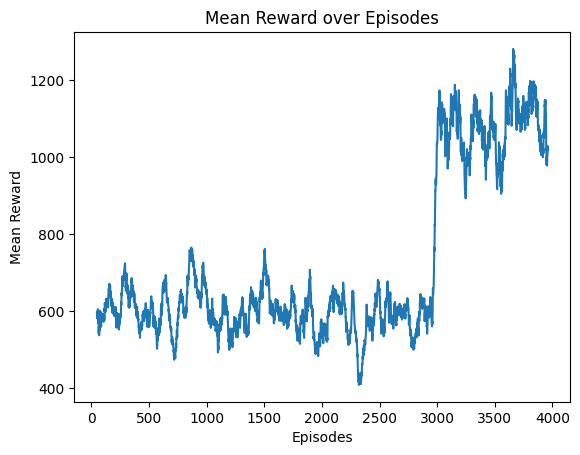

In [64]:
# Load the log file (which is a CSV)
log_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/monitor.csv', skiprows=1)

# Calculate the episode mean reward
mean_reward = log_data['r'].rolling(window=50).mean()  # Smooth the rewards

# Plot the mean reward
plt.plot(mean_reward)
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward over Episodes')
plt.show()

In [47]:
model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_900000_steps.zip", env=env)

Wrapping the env in a DummyVecEnv.


In [48]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[  2   4  32 128]
 [  2   4  16  32]
 [  2  16   4  16]
 [  2   8   2   4]]
1057.0
136


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


In [62]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'wb') as file:
    pickle.dump(data, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


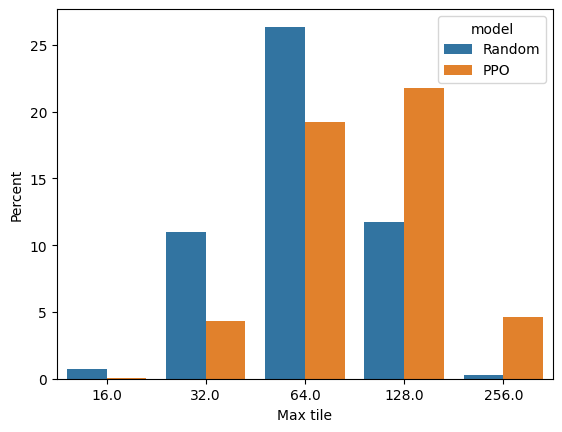

In [63]:
with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'rb') as file:
    data = pickle.load(file)

df_model = pd.DataFrame({'max_tiles':data['max_tiles']})
df_model['model'] = "PPO"

df = pd.concat([df_random, df_model], ignore_index=True)

sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.show()

# DQN stable baselines 3

In [ ]:
env = Monitor(env, filename="./logs/dqn_cnn_2024_10_27.csv")

#model = DQN(
#    "CnnPolicy",
#    env,
#    verbose=1,
#    policy_kwargs=policy_kwargs,
#    batch_size=512,
#    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/",
#    device='mps',
#    buffer_size=50000,
#    learning_rate=0.001
#    )

model = DQN.load(
    "./DQN_CNN_2024_10_26/rl_model_900000_steps.zip",
    env=env,
    learning_rate=0.001,
    batch_size=512,
    buffer_size=50000,
    device='mps',
    load_replay_buffer=True,
    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/"
)

print("Learning rate: %0.4f" % model.learning_rate)

plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./DQN_CNN_2024_10_27/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])

model.learn(total_timesteps=int(2e6), reset_num_timesteps=False, progress_bar=False, callback=callback)

In [111]:
model = DQN.load("./DQN_CNN_2024_10_27/rl_model_2250000_steps.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [49]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

[[  2.   4.  16.  32.]
 [  2.  16.  32. 256.]
 [  4.   8.  16.  64.]
 [  4.   2.   4.  16.]]
2421.0
238


In [ ]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

#with open('./2048_dqn_225k.pkl', 'wb') as file:
#    pickle.dump(data, file)

# TD-learning

In [14]:
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, buffer_size, observation_space, action_space, alpha=0.6, beta=0.4, beta_increment=1e-4, eps=1e-6, rank_based=True, **kwargs):
        super(PrioritizedReplayBuffer, self).__init__(buffer_size, observation_space, action_space, **kwargs)
        self.alpha = alpha  # Controls how much prioritization is used (0 is uniform, 1 is full prioritization)
        self.beta = beta  # Controls how much importance-sampling correction is used
        self.beta_increment = beta_increment  # Rate at which beta increases to 1
        self.eps = eps
        self.rank_based = rank_based
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)  # Initialize priorities to zero

    def add(self, *args, **kwargs):
        # Add a transition with the maximum priority
        max_priority = self.priorities.max() if self.size() > 0 else 1.0
        super(PrioritizedReplayBuffer, self).add(*args, **kwargs)
        self.priorities[self.pos - 1] = max_priority  # Set priority for the new transition

    def sample(self, batch_size):
        # Calculate sampling probabilities
        #if self.size == self.buffer_size:
        #    probs = self.priorities ** self.alpha
        #else:
        #    probs = self.priorities[:self.pos] ** self.alpha
        probs = self.priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample a batch of indices based on probabilities
        indices = np.random.choice(len(probs), size=batch_size, p=probs)
        batch = super(PrioritizedReplayBuffer, self)._get_samples(indices)
        
        # Calculate importance-sampling weights
        total = len(probs)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize for stability
        weights = torch.tensor(weights)

        # Update beta toward 1 over time
        self.beta = min(1.0, self.beta + self.beta_increment)

        #return batch, indices, weights
        return batch, weights

    def update_priorities(self, policy_network, target_network):
        states = torch.tensor(self.observations).squeeze(1).to(self.device)
        rewards = torch.tensor(self.rewards).to(self.device)
        next_states = torch.tensor(self.next_observations).squeeze(1).to(self.device)

        with torch.no_grad():
            states_values = policy_network.forward(states)
            next_states_values = target_network.forward(next_states)

            td_errors = torch.abs(rewards + next_states_values - states_values).view(-1)

            if self.rank_based:
                sorted_indices = torch.argsort(td_errors, descending=True).to(self.device)
                ranks = torch.empty_like(sorted_indices)
                ranks[sorted_indices] = torch.arange(len(td_errors)).to(self.device)
                self.priorities = (1/(ranks+1)).cpu().numpy()
            else:
                self.priorities = td_errors.cpu().numpy().flatten() + self.eps

In [50]:
class TDL():
    def __init__(self, network, env, device="mps"):
        self.env = env
        self.device = device

        self.policy_network = network(self.env.observation_space).to(device)
        self.target_network = network(self.env.observation_space).to(device)

        self.policy_network.apply(CNN22_TDL.truncated_normal_init)
        self.target_network.apply(CNN22_TDL.truncated_normal_init)

    def load_network(self, network_dict_path):
        self.policy_network.load_state_dict(torch.load(network_dict_path))
        self.target_network.load_state_dict(torch.load(network_dict_path))

    def predict(self, observation, device="mps", verbose=False):
        # Generate all afterstates in a list
        afterstates = []
        rewards = []

        isAllowed = self.env.unwrapped.allowed_actions()
        
        for action in range(self.env.action_space.n):
            new_afterstate, reward = self.env.unwrapped.afterstate(observation, action)
            afterstates.append(new_afterstate)
            if isAllowed[action]:
                rewards.append(reward)
            else:
                rewards.append(-np.Inf)
        
        # Convert afterstates to a tensor and move to the device in one go
        afterstates_tensor = torch.tensor(np.array(afterstates)).to(device)
        
        # Forward pass for all afterstates at once
        afterstate_values = self.policy_network.forward(afterstates_tensor).squeeze(1).detach().cpu().numpy()
        
        # Combine rewards and afterstate values
        evaluate = np.array(rewards) + afterstate_values
        
        # Get the best action
        best_action = np.argmax(evaluate)

        ## DEBUG
        if verbose:
            print("State\n")
            print(self.env.decode(observation))

            for action in range(self.env.action_space.n):
                print("Action: "+str(action))
                print("Afterstate")
                print(self.env.decode(afterstates[action]))
                print("Reward: "+str(rewards[action]))
                print("Afterstate value: "+str(afterstate_values[action]))
            
            print("Best action: " + str(best_action))
            print("Evaluate: " + str(evaluate[best_action]))
        
        return best_action, evaluate[best_action]

    def eval(self):
        self.policy_network.eval()
        return
    
    def train(self):
        self.policy_network.train()
        return

    def plot_callback(self, loss, episode_rewards, max_tiles, epsilons, plot_save, save_path):
        clear_output(wait=True)  # Clear the previous plot

        # Create the subplot layout
        fig, axes = plt.subplots(4, 1, figsize=(8, 16))
        fig.subplots_adjust(hspace=0.4)  # Adjust space between plots

        # Reward per episode plot (first row, spans both columns)
        axes[0].semilogy(loss, label="Loss", color="black")
        axes[0].set_title("Loss per Training Step")
        axes[0].set_xlabel("Training step")
        axes[0].set_ylabel("Loss")
        axes[0].legend()
        axes[0].grid()

        # Reward per episode plot (first row, spans both columns)
        axes[1].plot(episode_rewards, label="Episode Reward")
        if len(episode_rewards) >= 100:
            df1 = pd.DataFrame({'episode_rewards':episode_rewards})
            df1['rolling_avg'] = df1['episode_rewards'].rolling(window=100).mean()
            axes[1].plot(df1['rolling_avg'], color="orange")
        axes[1].set_title("Reward per Episode")
        axes[1].set_xlabel("Episode")
        axes[1].set_ylabel("Reward")
        axes[1].legend()
        axes[1].grid()

        # Epsilon threshold plot (second row, first column)
        axes[2].plot(epsilons, color="orange", label="Epsilon")
        axes[2].set_title("Epsilon Threshold Over Timesteps")
        axes[2].set_xlabel("Timestep")
        axes[2].set_ylabel("Epsilon")
        axes[2].set_ylim(0, 1.0)
        axes[2].legend()
        axes[2].grid()

        # Max score reached plot (second row, second column)
        axes[3].plot(max_tiles, 'o', color="red", label="Max Score")
        if len(episode_rewards) >= 100:
            df2 = pd.DataFrame({'max_tiles':max_tiles})
            df2['rolling_avg'] = df2['max_tiles'].rolling(window=100).mean()
            axes[3].plot(df2['rolling_avg'], color="orange")
        axes[3].set_title("Max Tile Reached")
        axes[3].set_xlabel("Episode")
        axes[3].set_ylabel("Max Tile")
        axes[3].legend()
        axes[3].grid()

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Save
        if plot_save:
            fig.savefig(save_path+'logs.png', dpi=300, bbox_inches='tight')

    def symmetries(self, states, expected_states_values, weights):
        states_rot90 = torch.rot90(states, k=1, dims=(-2, -1))
        states_rot180 = torch.rot90(states, k=2, dims=(-2, -1))
        states_rot270 = torch.rot90(states, k=3, dims=(-2, -1))
        states_flip = torch.flip(states, dims=[-2])
        states_rot90_flip = torch.flip(states_rot90, dims=[-2])
        states_rot180_flip = torch.flip(states_rot180, dims=[-2])
        states_rot270_flip = torch.flip(states_rot270, dims=[-2])

        states = torch.cat((states, states_rot90, states_rot180, states_rot270, states_flip, states_rot90_flip, states_rot180_flip, states_rot270_flip), dim=0)
        expected_states_values = torch.cat((expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values), dim=0)
        if type(weights) == torch.Tensor:
            weights = torch.cat((weights, weights, weights, weights, weights, weights, weights, weights))
            weights = weights / 8
        return states, expected_states_values, weights

    def optimize_model(self, optimizer, lr=0.0001, gamma=0.99, use_target_network=True, device="mps", check_gradient=False, timestep=0, symmetry=False, save_path='./'):
        if self.replay_buffer.size() < self.batch_size:
            return

        # Sample from replay buffer
        if self.prioritized_replay:
            replay_data, weights = self.replay_buffer.sample(self.batch_size)
            weights = weights.to(device)
        else:
            replay_data = self.replay_buffer.sample(self.batch_size)
            weights = 1

        afterstates = replay_data.observations.to(device)
        next_afterstates = replay_data.next_observations.to(device)
        rewards = replay_data.rewards.to(device)
        dones = replay_data.dones.to(device)

        # Compute loss
        with torch.no_grad():
            if use_target_network:
                next_afterstates_values = self.target_network.forward(next_afterstates).detach()
            else:
                next_afterstates_values = self.policy_network.forward(next_afterstates).detach()
        expected_afterstates_values = (next_afterstates_values*gamma + rewards) * (dones == True)

        # Data augmentation: 8 symmetric positions all have same expected values
        if symmetry:
            afterstates, expected_afterstates_values, weights = self.symmetries(afterstates, expected_afterstates_values, weights)

        afterstates_values = self.policy_network.forward(afterstates)

        weighted_expected_afterstates_values = weights * expected_afterstates_values
        weighted_afterstates_values = weights * afterstates_values

        criterion = nn.MSELoss()
        loss = criterion(weighted_afterstates_values, weighted_expected_afterstates_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Check gradients
        if check_gradient:
            check_gradients(self.policy_network, timestep, save_path=save_path, threshold_min=1e-6, threshold_max=1e2, verbose=False)
        # In-place gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)
        optimizer.step()

        return loss.cpu().detach().numpy()

    def learn(self, total_timesteps, lr=0.0001, batch_size=512, train_freq=1, buffer_size=50000, prioritized_replay=False, prioritized_replay_alpha=0.6, prioritized_replay_beta=0.4, prioritized_replay_beta_increment=1e-4, reprioritize_freq=500, eps_start=0.9, eps_end=0.02, exploration_fraction=0.1, gamma=0.99, target_network_update_freq=500, save_path='./save_dir', save_freq=500, check_gradient_freq=500, jump=False, symmetry=False):
        # Create folder for training
        os.makedirs(save_path, exist_ok=True)

        # Save training parameters to folder
        data = {
            "total_timesteps": total_timesteps,
            "lr": lr,
            "batch_size": batch_size,
            "train_freq": train_freq,
            "buffer_size": buffer_size,
            "prioritized_replay": prioritized_replay,
            "prioritized_replay_alpha": prioritized_replay_alpha,
            "prioritized_replay_beta": prioritized_replay_beta,
            "prioritized_replay_beta_increment": prioritized_replay_beta_increment,
            "reprioritize_freq": reprioritize_freq,
            "eps_start": eps_start,
            "eps_end": eps_end,
            "exploration_fraction": exploration_fraction,
            "gamma": gamma,
            "target_network_update_freq": target_network_update_freq,
            "symmetry": symmetry,
            "jump": jump
        }

        with open(save_path + "training_parameters.json", "w") as json_file:
            json.dump(data, json_file, indent=4)

        optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        i_timestep = 0 
        i_episode = 0
        loss = np.array([])
        episode_rewards = np.array([])
        max_tiles = np.array([])
        epsilons = np.array([]) 

        self.train()

        self.batch_size = batch_size
        self.prioritized_replay = prioritized_replay
        self.reprioritize_freq = reprioritize_freq
        if prioritized_replay:
            self.replay_buffer = PrioritizedReplayBuffer(buffer_size, self.env.observation_space, self.env.action_space, alpha=prioritized_replay_alpha, beta=prioritized_replay_beta, beta_increment=prioritized_replay_beta_increment, device=self.device)
        else:
            self.replay_buffer = ReplayBuffer(buffer_size, self.env.observation_space, self.env.action_space, device=self.device)

        replay_buffer_size = asizeof.asizeof(self.replay_buffer)
        print(f"Accurate replay buffer memory size: {replay_buffer_size / 1024 ** 2:.2f} MB")

        while i_timestep < total_timesteps:
            i_episode += 1
            firstMove = True
            
            state, _ = self.env.reset(jump=jump)

            #max_tiles = np.append(max_tiles, - np.max(self.env.unwrapped.decode(state)))
            terminated = False
            episode_reward = 0
            
            while not terminated:
                i_timestep += 1

                if i_timestep > exploration_fraction * total_timesteps:
                    eps_threshold = eps_end
                else:
                    eps_threshold = eps_start - i_timestep / total_timesteps / exploration_fraction * (eps_start - eps_end)
                epsilons = np.append(epsilons, eps_threshold)

                if random.random() > eps_threshold:
                    action, _ = self.predict(state)
                else:
                    allowed_actions = self.env.unwrapped.allowed_actions()
                    isAllowed = False
                    while not(isAllowed):
                        action = self.env.action_space.sample()
                        isAllowed = allowed_actions[action]

                next_afterstate, reward = self.env.unwrapped.afterstate(state, action)
                state, reward, terminated, _, _ = self.env.unwrapped.step(action)
                episode_reward += reward

                # Store state, after state and reward into replay buffer
                if not(firstMove):
                    self.replay_buffer.add(afterstate, next_afterstate, np.array([action]), reward, False, np.array([{}]))
                    if terminated:
                        self.replay_buffer.add(next_afterstate, next_afterstate, np.array([action]), 0, True, np.array([{}]))

                firstMove = False
                afterstate = next_afterstate

                # Optimize model
                check_gradient = i_timestep % check_gradient_freq == 0 and i_timestep > 1
                use_target_network = target_network_update_freq > 0
                if i_timestep % train_freq == 0:
                    i_loss = self.optimize_model(optimizer, lr=lr, gamma=gamma, use_target_network=use_target_network, check_gradient=check_gradient, timestep=i_timestep, save_path=save_path)
                    loss = np.append(loss, i_loss)

                # Update target network
                if i_timestep % target_network_update_freq == 0 and target_network_update_freq > 0:
                    target_net_state_dict = self.target_network.state_dict()
                    policy_net_state_dict = self.policy_network.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]
                    self.target_network.load_state_dict(target_net_state_dict)

                # Update priorities of prioritized replay buffer
                if self.prioritized_replay:
                    if i_timestep % self.reprioritize_freq == 0:
                        self.replay_buffer.update_priorities(self.policy_network, self.target_network)
            
            episode_rewards = np.append(episode_rewards, episode_reward)
            #max_tiles[i_episode-1] += np.max(self.env.unwrapped.decode(state))
            max_tiles = np.append(max_tiles, np.max(self.env.unwrapped.decode(state)))
            # Plot episode reward
            plot_save = i_episode % save_freq == 0 and i_episode > 1
            self.plot_callback(loss, episode_rewards, max_tiles, epsilons, plot_save, save_path)
            # Save model checkpoint
            if i_episode % save_freq == 0 and i_episode > 1:
                PATH = save_path + 'rl_model_%i_epsiodes.zip' % i_episode
                torch.save(self.policy_network.state_dict(), PATH)

In [53]:
network = CNN22_TDL
env = Monitor(env, filename="./logs/tdl_cnn_2024_11_14.csv")
model = TDL(network, env, device="mps")
#model.load_network('./TDL_CNN_2024_11_10_1/rl_model_10000_epsiodes.zip')

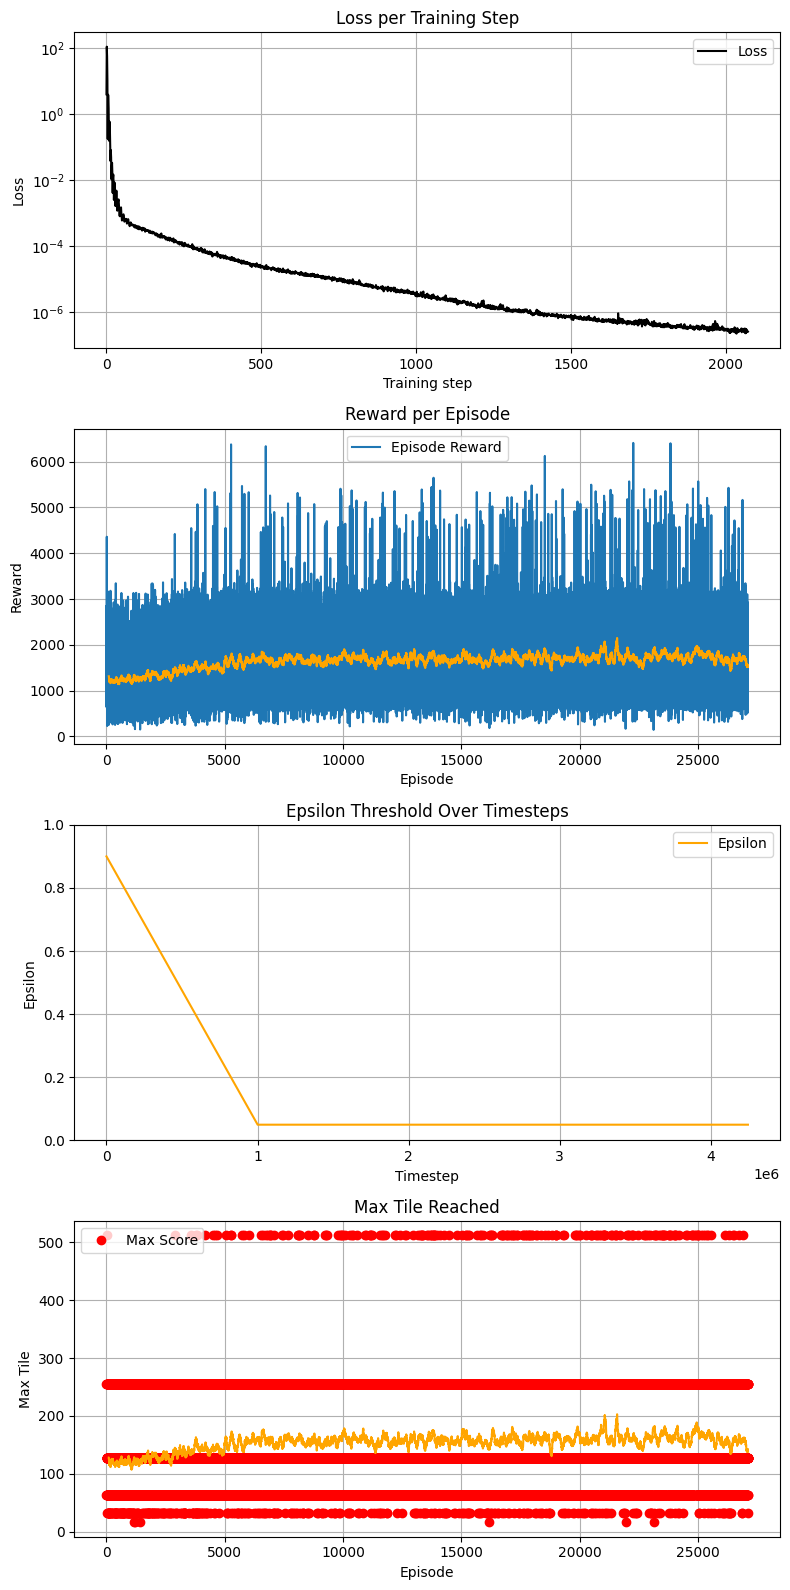

KeyboardInterrupt: 

In [ ]:
#profiler = cProfile.Profile()
#profiler.enable()

model.learn(
    1e7, 
    lr=1e-3,
    gamma=0.99,
    train_freq=1024,
    eps_start=0.0, 
    eps_end=0.0, 
    exploration_fraction=0.05,
    target_network_update_freq=-1, # set to -1 to not use target network
    save_path='./TDL_CNN_2024_11_14_1/', 
    save_freq=2500,
    check_gradient_freq=10,
    jump=False,
    symmetry=False,
    batch_size=1024, 
    buffer_size=1024, 
    prioritized_replay=False, 
    reprioritize_freq=300
    )

#profiler.disable()
#stats = pstats.Stats(profiler)

In [32]:
#stats.dump_stats('./profile_results.prof')

In [57]:
#network = CNN22_TDL
#env = gym2048.gym2048()
#model = TDL(network, env, batch_size=1024, buffer_size=1024, prioritized_replay=False, reprioritize_freq=300)
#model.load_network('./TDL_CNN_2024_11_13_1/rl_model_5000_epsiodes.zip')

model.eval()

print_intermediate = False

max_tile = 0

terminated = False

state, info = model.env.reset()

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, value = model.predict(state, verbose=False)
  next_afterstate, reward = model.env.afterstate(state, action)
  state, reward, terminated, _, _ = model.env.step(action)
  cum_reward += reward

  print(['left','right','up','down'][action])
  print(model.env.unwrapped.decode(state))
  print(reward)
  print(value)

print(model.env.unwrapped.decode(state))
print(cum_reward)
print(cpt)

/opt/homebrew/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.afterstate to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.afterstate` for environment variables or `env.get_wrapper_attr('afterstate')` that will search the reminding wrappers.
  logger.warn(


left
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 0.]]
0.0
4.5267981477081776e-05
up
[[4. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
4.0
3.999873473891057
right
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 2.]
 [0. 4. 0. 0.]]
0.0
0.000508005847223103
down
[[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 4.]
 [0. 4. 0. 4.]]
4.0
3.999861132935621
down
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 8.]]
8.0
7.999868285143748
right
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 2.]
 [0. 2. 4. 8.]]
0.0
0.00023796677123755217
down
[[0. 0. 4. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 2. 4. 8.]]
4.0
3.9997604518430308
down
[[0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 2. 8. 8.]]
8.0
8.000247227610089
right
[[ 0.  2.  0.  2.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  4.]
 [ 0.  0.  2. 16.]]
16.0
15.999510477413423
right
[[ 0.  0.  0.  4.]
 [ 0.  0.  2.  0.]
 [ 0.  0.  0.  4.]
 [ 0.  0.  2. 16.]]
4.0
3.9993806657148525
up
[[ 0.  0.  4.  8.]
 [ 0.  2.  0. 16.]
 [ 0.  0.  0.  0.]
 [ 0.  0.

In [64]:
state, _ = model.env.unwrapped.reset()
print(state)
print(model.env.unwrapped.decode(state))

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[0. 2. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [59]:
def get_param_stats(model):
    stats = {
        "Layer": [],
        "Min": [],
        "Max": [],
        "Mean": [],
        "Std": [],
        "Num Params": []
    }

    for name, param in model.named_parameters():
        if param.requires_grad:
            stats["Layer"].append(name)
            stats["Min"].append(param.data.min().item())
            stats["Max"].append(param.data.max().item())
            stats["Mean"].append(param.data.mean().item())
            stats["Std"].append(param.data.std().item())
            stats["Num Params"].append(param.numel())

    # Convert to DataFrame for easy viewing
    stats_df = pd.DataFrame(stats)
    return stats_df

# Example usage
model_stats = get_param_stats(model.policy_network)
print(model_stats)

          Layer       Min       Max      Mean       Std  Num Params
0  cnn.0.weight -0.213963  0.202965 -0.004163  0.085983       13312
1    cnn.0.bias -0.029492  0.022094 -0.009075  0.008314         256
2  cnn.2.weight -0.220239  0.210323 -0.006631  0.087817      524288
3    cnn.2.bias -0.018544  0.013832 -0.007819  0.004616         512
4   fc.0.weight -0.336800  0.362340 -0.003032  0.088152     2097152
5     fc.0.bias -0.019861  0.128351 -0.004470  0.008506        1024
6   fc.2.weight -0.390814  0.448630 -0.004289  0.088255      262144
7     fc.2.bias -0.021663  0.002038 -0.006461  0.003128         256
8   fc.4.weight -0.189254  0.191925 -0.001699  0.081168         256
9     fc.4.bias -0.001140 -0.001140 -0.001140       NaN           1


In [58]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./2048_tdl_cnn_2024_11_13_7500.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████| 1000/1000 [06:47<00:00,  2.46it/s]


# Comparison

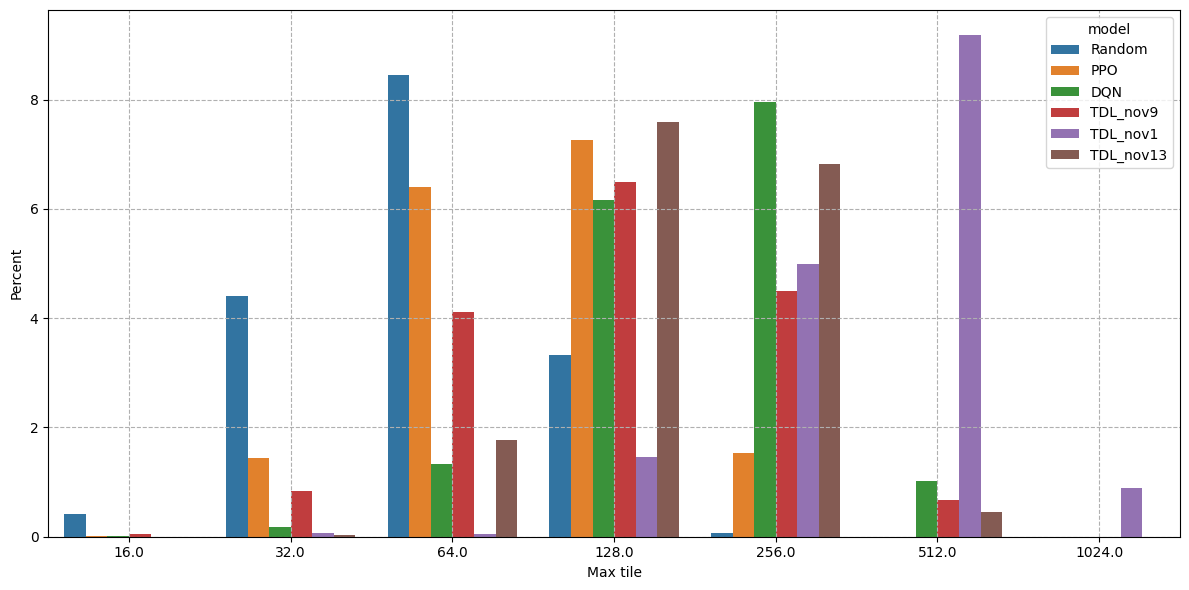

In [59]:
models = {
    'Random': './2048_random.pkl',
    'PPO': './2048_ppo.pkl',
    'DQN': './2048_dqn_165k.pkl',
    'TDL_nov1': './2048_tdl_3500.pkl',
    'TDL_nov9': './2048_tdl_cnn_2024_11_09_2500.pkl',
    'TDL_nov13': './2048_tdl_cnn_2024_11_13_7500.pkl'
}

df = pd.DataFrame()

for id, path in models.items():
    with open(path, 'rb') as file:
        data = pickle.load(file)
    df_loc = pd.DataFrame({'max_tiles':data['max_tiles']})
    df_loc['model'] = id
    df = pd.concat([df, df_loc], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()